In [5]:
# Install required libraries
!pip install transformers torch scikit-learn pandas matplotlib seaborn wordcloud

# Import necessary libraries
import pandas as pd
import torch
import os
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [6]:
#Ensure reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
#Disable Weights & Biases logging to avoid unnecessary API key prompt
os.environ["WANDB_DISABLED"] = "true"

In [8]:
#Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
#Define file paths
train_path = r"C:\Users\Tushar Malankar\Downloads\nlp-getting-started\train.csv"
test_path = r"C:\Users\Tushar Malankar\Downloads\nlp-getting-started\test.csv"
submission_path = r"C:\Users\Tushar Malankar\Downloads\nlp-getting-started\submission.csv"

In [10]:
#Load the datasets
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
except FileNotFoundError:
    print("⚠️ Error: CSV files not found. Ensure the file paths are correct.")
    exit()

In [11]:
#Check dataset structure
print("\n🔹 Train Dataset Sample:\n", train_df.head())
print("\n🔹 Test Dataset Sample:\n", test_df.head())


🔹 Train Dataset Sample:
    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

🔹 Test Dataset Sample:
    id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor

In [12]:
#Ensure columns exist in the dataset
required_columns = {"text", "target"}
if not required_columns.issubset(train_df.columns):
    print(f"⚠️ Error: Train dataset must contain {required_columns}. Found columns: {train_df.columns}")
    exit()

In [13]:
#Basic dataset info
print("\n🔹 Dataset Information:")
print(train_df.info())


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [14]:
#Check for missing values
print("\n🔹 Missing Values:\n", train_df.isnull().sum())


🔹 Missing Values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


C:\Users\Tushar Malankar\AppData\Local\Temp\ipykernel_43080\3294069865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df["target"], palette="coolwarm")


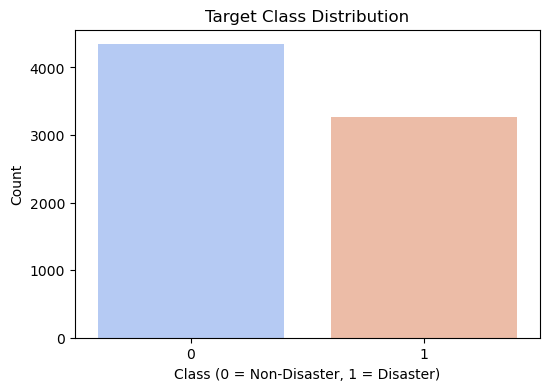

In [15]:
#Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_df["target"], palette="coolwarm")
plt.title("Target Class Distribution")
plt.xlabel("Class (0 = Non-Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()

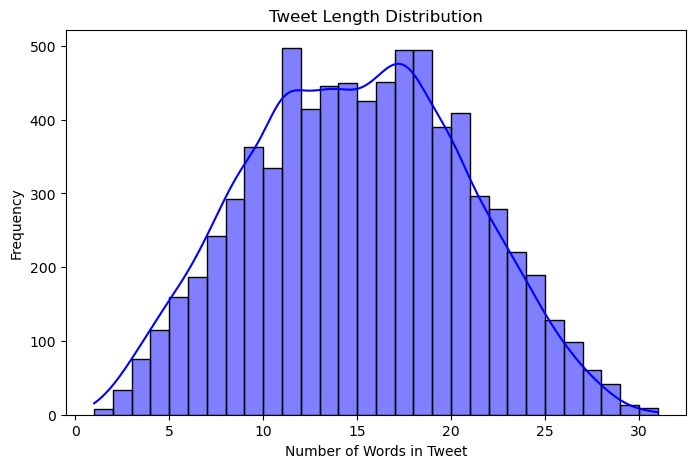

In [16]:
#Check tweet length distribution
train_df["text_length"] = train_df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df["text_length"], bins=30, kde=True, color="blue")
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.show()

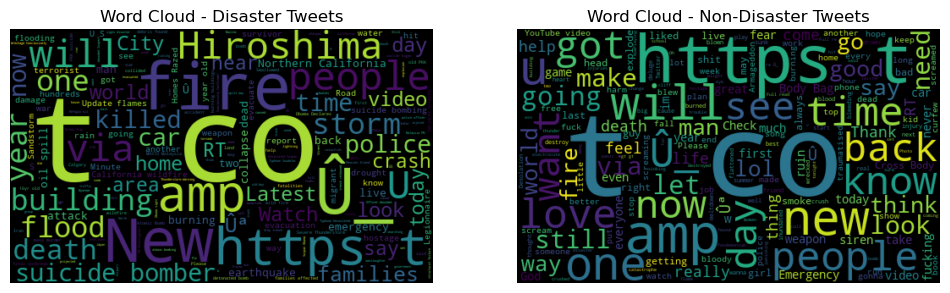

In [17]:
#Generate a Word Cloud for disaster tweets
disaster_text = " ".join(train_df[train_df["target"] == 1]["text"])
non_disaster_text = " ".join(train_df[train_df["target"] == 0]["text"])

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
wordcloud1 = WordCloud(width=500, height=300, background_color="black").generate(disaster_text)
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Disaster Tweets")

plt.subplot(1, 2, 2)
wordcloud2 = WordCloud(width=500, height=300, background_color="black").generate(non_disaster_text)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Non-Disaster Tweets")

plt.show()

In [18]:
#Check some sample tweets
print("\n🔹 Sample Disaster Tweets:")
print(train_df[train_df["target"] == 1]["text"].sample(5, random_state=SEED))

print("\n🔹 Sample Non-Disaster Tweets:")
print(train_df[train_df["target"] == 0]["text"].sample(5, random_state=SEED))


🔹 Sample Disaster Tweets:
4008    Nearly 50 thousand people affected by floods i...
325     Vladimir Putin Issues Major Warning But Is It ...
1215    @DoctorFluxx @StefanEJones @spinnellii @themer...
494     Telnet attacked from 124.13.172.40 (STREAMYX-H...
2961    LONDON IS DROWNING AND IIII LIVE BY THE RIVEEE...
Name: text, dtype: object

🔹 Sample Non-Disaster Tweets:
3697    Everyday is a near death fatality for me on th...
4180    #Lifestyle Û÷It makes me sickÛª: Baby clothe...
4634    @Lenn_Len Probably. We are inundated with them...
6135    A demoness with the voice of an angel. Like a ...
4568    Next Man Up---AH SCREW THIS! I'm so tired of i...
Name: text, dtype: object


In [19]:
# ✅ Define BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [20]:
#Split training data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].tolist(), train_df["target"].tolist(), test_size=0.1, random_state=SEED
)

In [21]:
#Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

In [22]:
#Tokenize train and validation datasets
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

In [23]:
#Create PyTorch dataset class
class DisasterTweetDataset(Dataset):
    def __init__(self, encodings, labels):
        assert len(encodings["input_ids"]) == len(labels), "Dataset length mismatch!"
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [24]:
#Create train and validation datasets
train_dataset = DisasterTweetDataset(train_encodings, train_labels)
val_dataset = DisasterTweetDataset(val_encodings, val_labels)

In [25]:
#Load BERT model for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)  # Move model to the correct device

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:
#Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    run_name="bert_disaster_tweets",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
)

C:\Users\Tushar Malankar\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [27]:
#Create Trainer with training & validation datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [28]:
#Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.556000,0.502839
2,0.377500,0.515020
3,0.327100,0.600532


TrainOutput(global_step=2571, training_loss=0.4082119367503786, metrics={'train_runtime': 575.5999, 'train_samples_per_second': 35.707, 'train_steps_per_second': 4.467, 'total_flos': 1351930380203520.0, 'train_loss': 0.4082119367503786, 'epoch': 3.0})

In [29]:
#Evaluate model on validation set
val_predictions = trainer.predict(val_dataset)
val_predicted_labels = torch.argmax(torch.tensor(val_predictions.predictions), axis=1).cpu().numpy()

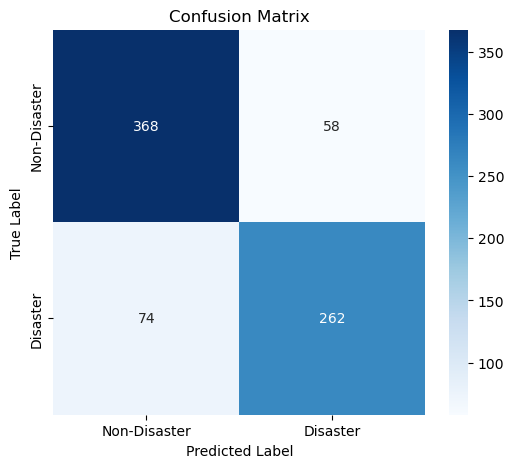

In [60]:
#Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Disaster", "Disaster"], yticklabels=["Non-Disaster", "Disaster"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [63]:
#Print classification report
print("\n🔹 Classification Report:\n", classification_report(val_labels, val_predicted_labels, target_names=["Non-Disaster", "Disaster"]))


🔹 Classification Report:
               precision    recall  f1-score   support

Non-Disaster       0.83      0.86      0.85       426
    Disaster       0.82      0.78      0.80       336

    accuracy                           0.83       762
   macro avg       0.83      0.82      0.82       762
weighted avg       0.83      0.83      0.83       762



In [65]:
#Predict on Test Data
test_encodings = tokenize_function(test_df["text"].tolist())

test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"])
)

test_dataloader = DataLoader(test_dataset, batch_size=8)

model.eval()
test_predicted_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_predicted_labels.extend(predictions.cpu().tolist())

submission_df = pd.DataFrame({"id": test_df["id"], "target": test_predicted_labels})
submission_df.to_csv(submission_path, index=False)

print(f"\nFinal submission saved at: {submission_path}")



Final submission saved at: C:\Users\Tushar Malankar\Downloads\nlp-getting-started\submission.csv
